In [ ]:
from fastai.text.all import *
from google.colab import drive
import pickle
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = Path('/content/gdrive/MyDrive/IASD_2/NLP/train.csv')

In [ ]:
import pandas as pd
df = pd.read_csv(path, encoding = 'latin1')
df = df.dropna()
df.columns = ['label', 'title', 'text']
df['text'] = df['title'].apply(str) + ' ' + df['text'].apply(str)
df.drop('title', axis = 1, inplace = True)

In [ ]:

df = df.head(100_000)
df.head()

,label,text
0,2,"The best soundtrack ever to anything. I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."
1,2,"Amazing! This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners of Fate"" (which means all the more if you've played the game) and the hope in ""A Distant Promise"" and ""Girl who Stole the Star"" have been an important inspiration to me personally throughout my teen years. The higher energy tracks like ""Chrono Cross ~ Time's Scar~"", ""Time of the Dreamwatch"", and ""Chronomantique"" (indefinably remeniscent of Chrono Trigger) are all absolutely superb as well.This soundtrack is amazing music, probably the best of this composer's work (I haven't heard the Xe..."
2,2,"Excellent Soundtrack I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favorites are Scars Of Time, Between Life and Death, Forest Of Illusion, Fortress of Ancient Dragons, Lost Fragment, and Drowned Valley.Disk Two: The Draggons, Galdorb - Home, Chronomantique, Prisoners of Fate, Gale, and my girlfriend likes ZelbessDisk Three: The best of the three. Garden Of God, Chronopolis, Fates, Jellyfish sea, Burning Orphange, Dragon's Prayer, Tower Of Stars, Dragon God, and R..."
3,2,"Remember, Pull Your Jaw Off The Floor After Hearing it If you've played the game, you know how divine the music is! Every single song tells a story of the game, it's that good! The greatest songs are without a doubt, Chrono Cross: Time's Scar, Magical Dreamers: The Wind, The Stars, and the Sea and Radical Dreamers: Unstolen Jewel. (Translation varies) This music is perfect if you ask me, the best it can be. Yasunori Mitsuda just poured his heart on and wrote it down on paper."
4,2,"an absolute masterpiece I am quite sure any of you actually taking the time to read this have played the game at least once, and heard at least a few of the tracks here. And whether you were aware of it or not, Mitsuda's music contributed greatly to the mood of every single minute of the whole game.Composed of 3 CDs and quite a few songs (I haven't an exact count), all of which are heart-rendering and impressively remarkable, this soundtrack is one I assure you you will not forget. It has everything for every listener -- from fast-paced and energetic (Dancing the Tokage or Termina Home), t..."


In [ ]:
dls_lm = TextDataLoaders.from_df(df, 
                                 text_col = 'text', 
                                 label_col = 'label', 
                                 valid_pct = 0.20, 
                                 bs = 64, 
                                 is_lm = True)
vocab = dls_lm.vocab

In [ ]:
dls_lm.show_batch(max_n = 1)

,text,text_
0,"xxbos xxmaj flimsy xxmaj as others have mentioned , the tiny plastic tabs that hold the sponge on snap off very easily . i figured i was just being too rough with it , so i went out and bought another one , and made sure to be more careful … had the same problem . xxmaj the sponges do n't last all that long , either . xxmaj the only thing","xxmaj flimsy xxmaj as others have mentioned , the tiny plastic tabs that hold the sponge on snap off very easily . i figured i was just being too rough with it , so i went out and bought another one , and made sure to be more careful … had the same problem . xxmaj the sponges do n't last all that long , either . xxmaj the only thing i"


In [ ]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult = 0.3)


SuggestedLRs(valley=0.002511886414140463)

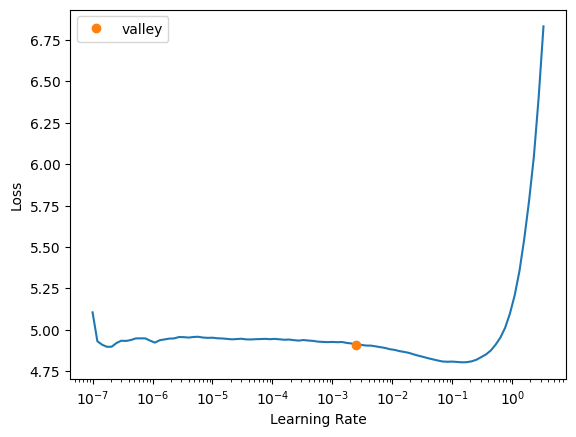

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 0.0025)

epoch,train_loss,valid_loss,time
0,4.120821,4.026080,13:17


In [ ]:
torch.save(learn.state_dict(), Path('/content/gdrive/MyDrive/IASD_2/NLP/Half_trained_100_000_LM.pt'))
#learn.load_state_dict(torch.load(Path('/content/gdrive/MyDrive/IASD_2/NLP/Half_trained_100_000_LM.pt')))

In [ ]:
learn.save_encoder('finetuned')

In [ ]:
vocab = []
with open("/content/gdrive/MyDrive/IASD_2/NLP/vocab.pkl", "rb") as fp:
  vocab = pickle.load(fp)

In [ ]:

dls_clas = TextDataLoaders.from_df(df, 
                        valid_pct = 0.2, 
                        text_col = 'text',
                        label_col = 'label', 
                        bs = 64, 
                        text_vocab = dls_lm.vocab)
dls_clas.show_batch(max_n = 1)

,text,category
0,xxbos xxup this xxup sucks xxup stay xxup away xxup buyer xxup beware ! ! ! yes xxup the xxup diapers xxup are xxup good xxup but i xxup received xxup the xxup diapers xxup with xxup stains xxup they xxup look xxup like xxup dna xxup stains . xxup so i xxup call xxup the xxup company xxup and xxup they xxup instruct xxup me xxup to xxup xxunk xxup them xxup away xxup all 200 xxup diapers xxup wow . xxup so i xxup wait xxup in xxup the xxup mail xxup for xxup some xxup coupons xxup they xxup are xxup supposed xxup to xxup send xxup me xxup and xxup turns xxup out i xxup have xxup to xxup spend xxup more xxup money xxup in xxup order xxup to xxup get xxup the xxup diapers i xxup had xxup already xxup paid xxup for .,1


In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult = 0.5, metrics = accuracy).to_fp16()


In [ ]:
learn = learn.load_encoder('finetuned')

In [ ]:

learn.summary()

SequentialRNN (Input shape: 64 x 399)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 39 x 1152      
LSTM                                                           
LSTM                                                           
____________________________________________________________________________
                     64 x 39 x 400       
LSTM                                                           
RNNDropout                                                     
RNNDropout                                                     
RNNDropout                                                     
BatchNorm1d                               2400       True      
Dropout                                                        
____________________________________________________________________________
                     64 x 50             
Linear                                    60000      True      
ReLU                                      

SuggestedLRs(valley=0.004365158267319202)

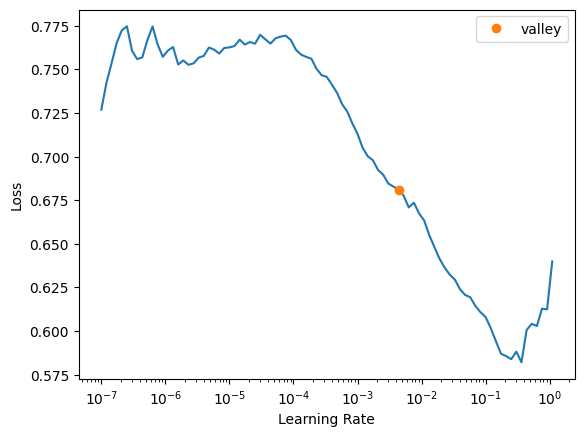

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 0.004)
torch.save(learn.state_dict(), Path('/content/gdrive/MyDrive/IASD_2/NLP/Half_trained_100_000.pt'))

epoch,train_loss,valid_loss,accuracy,time
0,0.373577,0.289489,0.880900,02:11


In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(10, 0.004)
torch.save(learn.state_dict(), Path('/content/gdrive/MyDrive/IASD_2/NLP/two_20_Half_trained_100_000.pt'))

epoch,train_loss,valid_loss,accuracy,time
0,0.136290,0.172048,0.939800,02:17
1,0.165256,0.185851,0.931650,02:17
2,0.171425,0.168310,0.936400,02:13
3,0.175477,0.166664,0.935700,02:16
4,0.155917,0.165017,0.940700,02:15
5,0.132767,0.178391,0.937000,02:13
6,0.120654,0.176619,0.939200,02:15
7,0.111688,0.171227,0.943200,02:15
8,0.096037,0.177034,0.941700,02:17
9,0.085917,0.179284,0.942050,02:17


In [ ]:
learn.freeze_to(-4)
learn.fit_one_cycle(1, 0.004)
torch.save(learn.state_dict(), Path('/content/gdrive/MyDrive/IASD_2/NLP/three_Half_trained_100_000.pt'))

epoch,train_loss,valid_loss,accuracy,time
0,0.132462,0.116098,0.958095,20:36


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, 0.004)
torch.save(learn.state_dict(), Path('/content/gdrive/MyDrive/IASD_2/NLP/full_1_trained_100_000.pt'))

epoch,train_loss,valid_loss,accuracy,time
0,0.116281,0.110179,0.961115,23:46


In [ ]:
learn.fit_one_cycle(1, 1e-3)
torch.save(learn.state_dict(), Path('/content/gdrive/MyDrive/IASD_2/NLP/full_2_trained_100_000.pt'))

epoch,train_loss,valid_loss,accuracy,time
0,0.109261,0.108443,0.961620,23:49


In [ ]:
learn.predict('This was a really good day in my life. My whole family except my dad was amazed.')

('2', tensor(1), tensor([0.0033, 0.9967]))

In [ ]:
path_test = Path('/content/gdrive/MyDrive/IASD_2/NLP/test.csv')
df_test = pd.read_csv(path_test, encoding = 'latin1')
df_test.columns = ['label', 'title', 'text']
df_test['text'] = df_test['title'].apply(str) + ' ' + df_test['text'].apply(str)
df_test.drop('title', axis = 1, inplace = True)
df_test = df_test.head(100_000)
df_test.head()

,label,text
0,2,"One of the best game music soundtracks - for a game I didn't really play Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of songs in my other video game soundtracks. I must admit that one of the songs (Life-A Distant Promise) has brought tears to my eyes on many o..."
1,1,"Batteries died within a year ... I bought this charger in Jul 2003 and it worked OK for a while. The design is nice and convenient. However, after about a year, the batteries would not hold a charge. Might as well just get alkaline disposables, or look elsewhere for a charger that comes with batteries that have better staying power."
2,2,"works fine, but Maha Energy is better Check out Maha Energy's website. Their Powerex MH-C204F charger works in 100 minutes for rapid charge, with option for slower charge (better for batteries). And they have 2200 mAh batteries."
3,2,"Great for the non-audiophile Reviewed quite a bit of the combo players and was hesitant due to unfavorable reviews and size of machines. I am weaning off my VHS collection, but don't want to replace them with DVD's. This unit is well built, easy to setup and resolution and special effects (no progressive scan for HDTV owners) suitable for many people looking for a versatile product.Cons- No universal remote."
4,1,"DVD Player crapped out after one year I also began having the incorrect disc problems that I've read about on here. The VCR still works, but hte DVD side is useless. I understand that DVD players sometimes just quit on you, but after not even one year? To me that's a sign on bad quality. I'm giving up JVC after this as well. I'm sticking to Sony or giving another brand a shot."


In [ ]:
torch.save(learn.state_dict(), Path('/content/gdrive/MyDrive/IASD_2/NLP/trained100_000.pt'))

In [ ]:
model = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult = 0.5, metrics = accuracy).to_fp16() 

In [ ]:
model.load_state_dict(torch.load(Path('/content/gdrive/MyDrive/IASD_2/NLP/trained100_000.pt')))

<All keys matched successfully>

In [ ]:
vocab = []
with open("/content/gdrive/MyDrive/IASD_2/NLP/vocab.pkl", "rb") as fp:
  vocab = pickle.load(fp)
dls_clas = TextDataLoaders.from_df(df, 
                        valid_pct = 0.2, 
                        text_col = 'text',
                        label_col = 'label', 
                        bs = 64, 
                        text_vocab = vocab
                        )
dls_clas.show_batch(max_n = 1)

,text,category
0,xxbos xxup huge xxup disappointment i xxup ordered 6 xxup of xxup them xxup for xxup christmas xxup gifts xxup and xxup picked xxup one xxup up xxup for xxup myself xxup this xxup morning xxup at xxup walmart . i xxup rushed xxup home xxup so xxup excited xxup to xxup listen xxup to xxup it xxup and xxup was xxup heart xxup broken . i xxup expected xxup to xxup hear xxup that xxup wonderful xxup voice i xxup grew xxup to xxup love xxup on xxup american xxup idol xxup and xxup it xxup was xxup far xxup from xxup it . xxup all i xxup heard xxup on xxup this xxup alum xxup was 2 xxup decent xxup sounding xxup songs . xxup the xxup rest xxup is a xxup huge xxup disappointment . xxup why xxup ruben xxup thinks xxup he xxup has xxup to,1


In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult = 0.5, metrics = accuracy).to_fp16()

In [ ]:
learn.summary()

SequentialRNN (Input shape: 64 x 416)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 56 x 1152      
LSTM                                                           
LSTM                                                           
____________________________________________________________________________
                     64 x 56 x 400       
LSTM                                                           
RNNDropout                                                     
RNNDropout                                                     
RNNDropout                                                     
BatchNorm1d                               2400       True      
Dropout                                                        
____________________________________________________________________________
                     64 x 50             
Linear                                    60000      True      
ReLU                                      

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.138957,0.122102,0.955980,23:48


In [ ]:

torch.save(learn.state_dict(), Path('/content/gdrive/MyDrive/IASD_2/NLP/one_trained_Classifier_only_100_000.pt'))

In [ ]:
learn.fit_one_cycle(1, 1e-3)
torch.save(learn.state_dict(), Path('/content/gdrive/MyDrive/IASD_2/NLP/two_trained_Classifier_only_100_000.pt'))

In [ ]:
vocab = []
with open("/content/gdrive/MyDrive/IASD_2/NLP/vocab.pkl", "rb") as fp:
  vocab = pickle.load(fp)

In [ ]:
dls_clas_test = TextDataLoaders.from_df(df_test, 
                        valid_pct = 0.2, 
                        text_col = 'text',
                        label_col = 'label', 
                        bs = 64, 
                        text_vocab = vocab
                        )

In [ ]:
learn = text_classifier_learner(dls_clas_test, AWD_LSTM, drop_mult = 0.5, metrics = accuracy).to_fp16()
#learn.load_state_dict(torch.load(Path('/content/gdrive/MyDrive/IASD_2/NLP/full_2_trained_100_000.pt')))
learn.load_state_dict(torch.load(Path('/content/gdrive/MyDrive/IASD_2/NLP/three_trained_Classifier_only_100_000.pt')))

<All keys matched successfully>

In [ ]:
dl = learn.dls.test_dl(df_test, bs=64)

In [ ]:
preds,  a = learn.get_preds(dl=dl)

In [ ]:
preds.argmax(axis=1)

tensor([1, 0, 1,  ..., 1, 0, 1])

In [ ]:
test_y = torch.tensor(df_test['label']) - 1
test_y

tensor([1, 0, 1,  ..., 1, 0, 1])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y, preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     49421
           1       0.96      0.95      0.96     50579

    accuracy                           0.96    100000
   macro avg       0.96      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y, preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     49421
           1       0.96      0.96      0.96     50579

    accuracy                           0.96    100000
   macro avg       0.96      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000



In [ ]:
(test_y == preds.argmax(axis=1)).sum()

tensor(95786)

In [ ]:
(test_y == preds.argmax(axis=1)).sum()

tensor(96080)